# BroIDS 日志分析

## 1 数据预处理

In [1]:
import os
conn_raw = os.getcwd() + os.sep * 2 + 'Data' + os.sep * 2 + 'Raw' + os.sep * 2 + 'conn.log'
dns_raw = os.getcwd() + os.sep * 2 + 'Data' + os.sep * 2 + 'Raw' + os.sep * 2 + 'dns.log'
conn_csv = os.getcwd() + os.sep * 2 + 'Data' + os.sep * 2 + 'CSV' + os.sep * 2 + 'conn.csv'
dns_csv = os.getcwd() + os.sep * 2 + 'Data' + os.sep * 2 + 'CSV' + os.sep * 2 + 'dns.csv'

### 1.1 提取conn日志

In [50]:
with open(conn_raw) as f:
    conn_li = f.read().splitlines()

In [51]:
# 使用正则表达式对字段进行提取
import re
conn_keys = re.findall(r'"([a-zA-Z0-9_@]+)[="]+[a-zA-Z0-9-./"_]+["]?,', conn_li[0])
conn_keys.remove('bro')
conn_keys.append('collector_node_id')

In [52]:
conn_values = []
for li in conn_li:
    row = []
    for key in conn_keys:
        regex = '\"' + key + '\"' + r'[="]+([a-zA-Z0-9-./_]+)["]?'
        pattern = re.compile(regex)
        res = re.findall(pattern, li)
        if(res):
            row.append(res[0])
        else:
            row.append('NaN')
    conn_values.append(row)

In [53]:
import pandas as pd
conn = pd.DataFrame(conn_values, columns=conn_keys)

In [54]:
conn.to_csv(conn_csv)

### 1.2 提取dns日志

In [17]:
with open(dns_raw) as f:
    dns_li = f.read().splitlines()

In [18]:
dns_values = []
for li in dns_li:
    dns_values.append(re.findall(r'"[a-zA-Z0-9_@]+[="]+([a-zA-Z0-9-./_]+)[",]?', li))

In [19]:
import pandas as pd
dns = pd.DataFrame(dns_values)

In [20]:
dns.to_csv(dns_csv)

## 2 特征工程

### 2.1 数据探索

In [107]:
import pandas as pd

conn_csv = os.getcwd() + os.sep * 2 + 'Data' + os.sep * 2 + 'CSV' + os.sep * 2 + 'conn.csv'
conn = pd.read_csv(conn_csv)

In [108]:
conn.head(5)

,ts,resp_pkts,id.resp_h,resp_l2_addr,orig_l2_addr,source,orig_bytes,duration,uid,LINE_ID,...,missed_bytes,id.resp_p,resp_ip_bytes,orig_pkts,history,GROUP_ID,batchtime,@timestamp,id.orig_p,proto
0,1.583000e+12,0,255.255.255.255,ff,2c,/opt/bro/spool/bro/conn.log,756.0,0.000850,CU4J7R1P5y36Y7BxAd,1001,...,0,5246,0,4,D,sie866f9,2020-03-01T01,2020-03-01T01,61232.0,udp
1,1.583020e+12,0,ff02,33,70,/opt/bro/spool/bro/conn.log,436.0,0.000012,Clx9kQ1sIR07W6W9re,1001,...,0,5246,0,2,D,sie866f9,2020-03-01T01,2020-03-01T01,5264.0,udp
2,1.583020e+12,0,ff02,33,84,/opt/bro/spool/bro/conn.log,100.0,0.000012,COalC812AiW73FHkV9,1001,...,0,547,0,2,D,sie866f9,2020-03-01T01,2020-03-01T01,546.0,udp
3,1.583000e+12,0,255.255.255.255,ff,84,/opt/bro/spool/bro/conn.log,756.0,0.000525,CsChNr4mTRcR9IP5Db,1001,...,0,5246,0,4,D,sie866f9,2020-03-01T01,2020-03-01T01,64570.0,udp
4,1.583000e+12,0,255.255.255.255,ff,84,/opt/bro/spool/bro/conn.log,756.0,0.000529,ClbASW3eMko1oMgGT8,1001,...,0,5246,0,4,D,sie866f9,2020-03-01T01,2020-03-01T01,63137.0,udp


In [100]:
print(conn.dtypes)
print('\n原始特征数: {0}个'.format(len(conn.dtypes)))

ts                 int64
resp_pkts          int64
id.resp_h         object
resp_l2_addr      object
orig_l2_addr      object
source            object
orig_bytes       float64
duration         float64
uid               object
LINE_ID            int64
local_resp          bool
cat               object
conn_state        object
host              object
local_orig          bool
service           object
offset             int64
id.orig_h         object
resp_bytes       float64
orig_ip_bytes      int64
missed_bytes       int64
id.resp_p          int64
resp_ip_bytes      int64
orig_pkts          int64
history           object
GROUP_ID          object
batchtime         object
@timestamp        object
id.orig_p        float64
proto             object
dtype: object

原始特征数: 30个


In [101]:
# 对缺失值进行处理
conn.isnull().sum()

ts                0
resp_pkts         0
id.resp_h         0
resp_l2_addr      0
orig_l2_addr      0
source            0
orig_bytes       69
duration         69
uid               0
LINE_ID           0
local_resp        0
cat               0
conn_state        0
host              0
local_orig        0
service           0
offset            0
id.orig_h         0
resp_bytes       69
orig_ip_bytes     0
missed_bytes      0
id.resp_p         0
resp_ip_bytes     0
orig_pkts         0
history           6
GROUP_ID          0
batchtime         0
@timestamp        1
id.orig_p         1
proto             0
dtype: int64

In [102]:
conn['orig_bytes'] = conn['orig_bytes'].fillna(0)
conn['duration'] = conn['duration'].fillna(0)
conn['resp_bytes'] = conn['resp_bytes'].fillna(0)

In [103]:
conn = conn.dropna(subset=['id.orig_p'])

In [104]:
conn[conn.history.isnull() == True]

,ts,resp_pkts,id.resp_h,resp_l2_addr,orig_l2_addr,source,orig_bytes,duration,uid,LINE_ID,...,missed_bytes,id.resp_p,resp_ip_bytes,orig_pkts,history,GROUP_ID,batchtime,@timestamp,id.orig_p,proto
5,1583014184772,0,ff02,33,7c,/opt/bro/spool/bro/conn.log,16.0,0.000017,CCmhWA3Gt3igBK7dEg,1001,...,0,134,0,2,NaN,sie866f9,2020-03-01T01,2020-03-01T01,133.0,icmp
266,1583021570131,0,129.103.84.215,0,7c,/opt/bro/spool/bro/conn.log,214.0,2.600429,CAG5Sy17AQkiR22awi,1001,...,0,3,0,2,NaN,sie866f9,2020-03-01T01,2020-03-01T01,3.0,icmp
404,1583011365450,0,129.103.84.215,0,7c,/opt/bro/spool/bro/conn.log,0.0,0.000000,CeustD4Ud0jXLBv7S1,1001,...,0,3,0,1,NaN,sie866f9,2020-03-01T01,2020-03-01T01,3.0,icmp
627,1583023117179,0,129.103.84.215,0,7c,/opt/bro/spool/bro/conn.log,0.0,0.000000,Cttqtp1Vx2PK1pZw53,1001,...,0,3,0,1,NaN,sie866f9,2020-03-01T01,2020-03-01T01,3.0,icmp
854,1582999443309,0,129.103.84.215,0,7c,/opt/bro/spool/bro/conn.log,476.0,4.929652,COYwrv3Vrp7pFXLKi9,1001,...,0,3,0,2,NaN,sie866f9,2020-03-01T01,2020-03-01T01,3.0,icmp
983,1583011392227,0,129.103.84.215,0,7c,/opt/bro/spool/bro/conn.log,476.0,4.933702,CkctZirOEHJlmgXlg,1001,...,0,3,0,2,NaN,sie866f9,2020-03-01T01,2020-03-01T01,3.0,icmp


In [105]:
conn['label'] = 'normal'

In [106]:
conn_fix = os.getcwd() + os.sep * 2 + 'Data' + os.sep * 2 + 'Fix' + 'conn_fix.csv'
conn.to_csv(conn_fix, index=False)

### 2.2 数据可视化

In [268]:
import pandas as pd

conn_fix = os.getcwd() + os.sep * 2 + 'Data' + os.sep * 2 + 'Fix' + 'conn_fix.csv'
conn = pd.read_csv(conn_fix)

In [269]:
conn.ts = pd.to_datetime(conn.ts, unit='ms')
conn.sort_values('ts', inplace=True)
conn.reset_index(inplace=True, drop=True)
conn.set_index('ts', inplace=True)

In [271]:
import matplotlib.pyplot as plt
import seaborn as sns

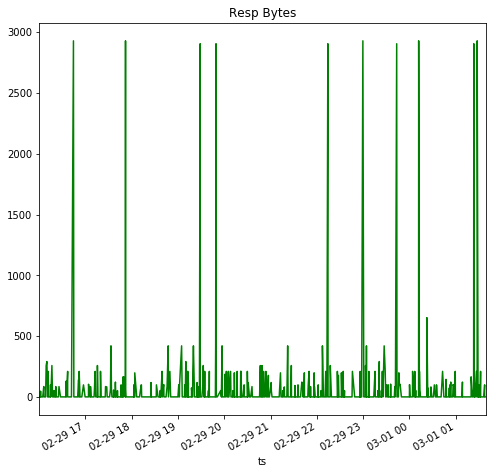

In [310]:
plt.title('Resp Bytes')
conn[5:].resp_bytes.plot(figsize=(8, 8), color='green')

## 3 模型构建

### 3.1 无监督学习

In [449]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

conn_fix = os.getcwd() + os.sep * 2 + 'Data' + os.sep * 2 + 'Fix' + 'conn_fix.csv'
conn = pd.read_csv(conn_fix)

In [450]:
X_train = conn[['id.resp_p', 'orig_bytes', 'resp_bytes', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'duration']]
X_test = X_train
y = conn.label

In [452]:
from pyod.models.pca import PCA
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.knn import KNN

clf = IForest(contamination=0.05)
clf.fit(X_train)
y_test_pred = clf.predict(X_test)
y_test_scores = clf.decision_function(X_test)
scores = pd.Series(y_test_scores)
pred = pd.Series(y_test_pred)
X_test['score'] = scores.values
X_test['pred'] = pred.values
conn['score'] = X_test['score']
conn['pred'] = X_test['pred']


In [454]:
print('正常数据: {0}条\n异常数据: {1}条'.format(len(conn[conn.pred == 0]), len(conn[conn.pred == 1])))

正常数据: 952条
异常数据: 47条


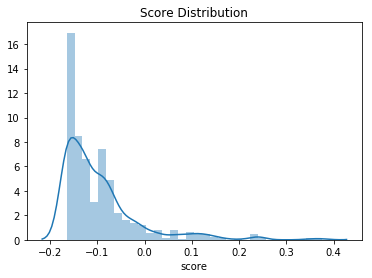

In [467]:
plt.title('Score Distribution')
sns.distplot(conn.score)

In [453]:
conn.label[conn.pred == 1] = 'abnormal'

In [455]:
top10 = conn[conn.pred == 1].sort_values(by='score', ascending=False)[:10]

In [456]:
import matplotlib.pyplot as plt
import seaborn as sns

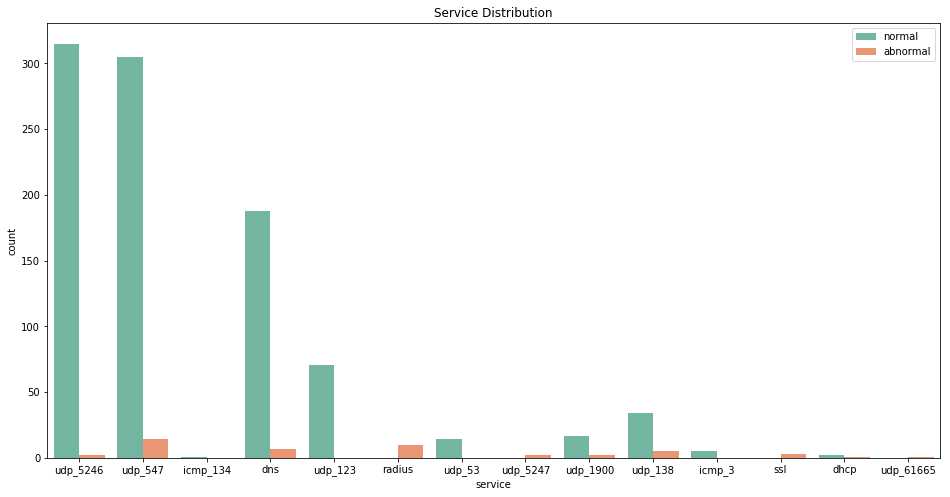

In [457]:
plt.figure(figsize=(16, 8))
plt.title('Service Distribution')
sns.countplot(hue='label', x='service', data=conn, palette='Set2')
plt.legend(loc='upper right')

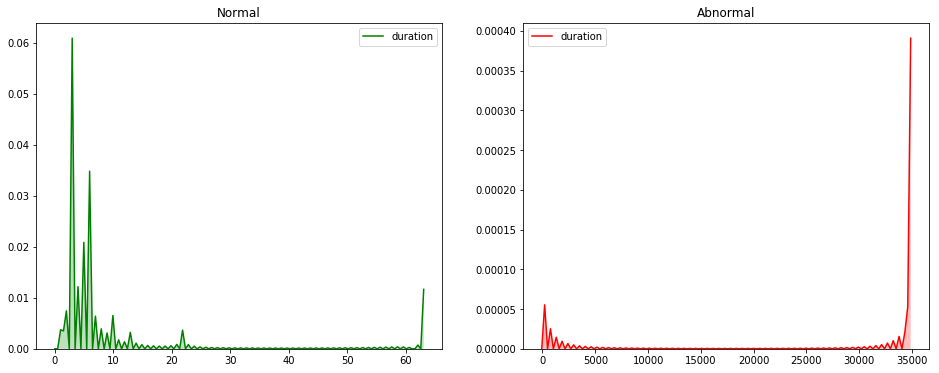

In [458]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].set_title('Normal')
axes[1].set_title('Abnormal')
sns.kdeplot(conn.duration[conn.pred == 0], shade=True, color='g', ax=axes[0])
sns.kdeplot(conn.duration[conn.pred == 1], shade=True, color='r', ax=axes[1])

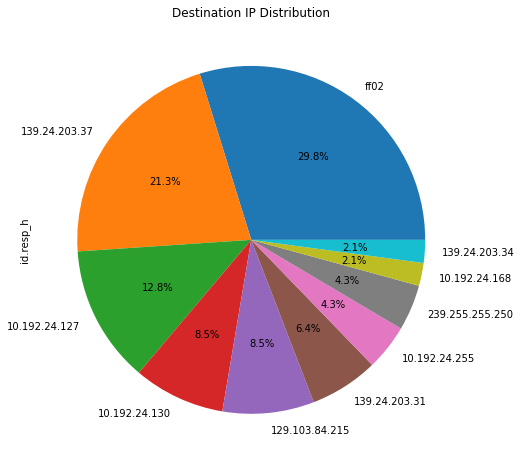

In [459]:
conn['id.resp_h'][conn.pred == 1].value_counts().plot.pie(autopct='%.1f%%', figsize=(8, 8), title='Destination IP Distribution')

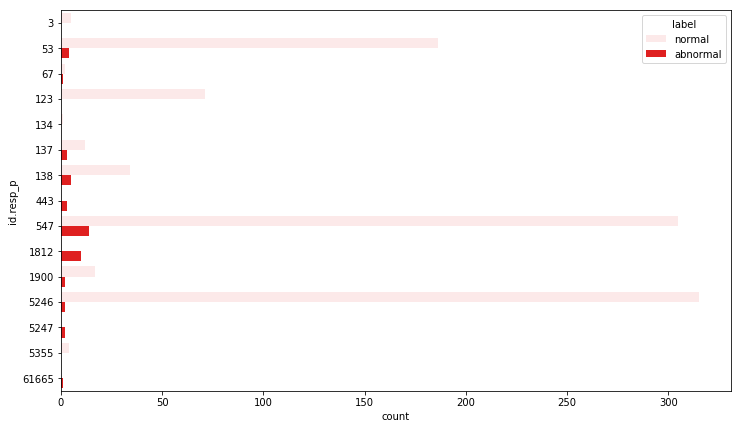

In [460]:
plt.figure(figsize=(12, 7))
sns.countplot(y='id.resp_p'
, hue='label', data=conn, color='red')

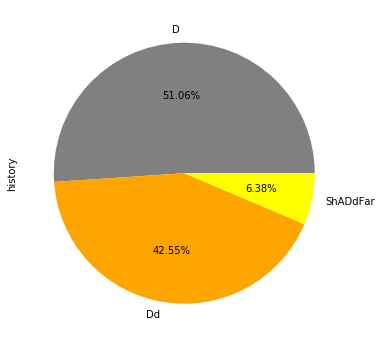

In [461]:
conn.history[conn.pred == 1].value_counts().plot.pie(figsize=(6, 6), autopct='%.2f%%', colors=['gray', 'orange', 'yellow'])